# **Multimodal RAG for Context Aware UAV Navigation**

**Environment Setup:**


In [1]:
#!pip install torch torchvision transformers faiss-cpu llama-index opencv-python numpy --quiet

import cv2
import torch
import numpy as np
import json
from transformers import (
    BlipProcessor, Blip2Processor, BlipForConditionalGeneration, Blip2ForConditionalGeneration,
    SegformerFeatureExtractor, SegformerForSemanticSegmentation
)
# ✅ New modular imports for llama-index >= 0.11
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.vector_stores.faiss import FaissVectorStore
from llama_index.core.schema import Document
import faiss
import os


**1) Vision Modality (BLIP + SegFormer):**

In [2]:
print("Torch version:", torch.__version__)
print("Device available:", "CUDA" if torch.cuda.is_available() else "CPU only")
print("OpenCV version:", cv2.__version__)

Torch version: 2.9.0
Device available: CPU only
OpenCV version: 4.12.0


In [3]:
from huggingface_hub import hf_hub_download
import tarfile
import os

# Create a lightweight local data folder
os.makedirs("uav_data/town01", exist_ok=True)

# Download ONE of the town splits (instead of all)
tar_path = hf_hub_download(
    repo_id="Peter341/Multi-View-UAV-Dataset",
    filename="town01_20241217_215934.tar",
    repo_type="dataset",   # or town02, town03 etc.
    local_dir="uav_data/town01"
)

# Extract
with tarfile.open(tar_path) as tar:
    tar.extractall(path="uav_data/town01")

print(" Extracted subset to:", os.path.abspath("uav_data/town01"))


✅ Extracted subset to: /Users/meena/Desktop/PROJECTS/llm for uav/CODE/uav_data/town01


In [4]:
import glob
from PIL import Image

image_files = glob.glob("uav_data/town01/**/*.png", recursive=True)[:100]
samples = [{"image_path": f, "image": Image.open(f).convert("RGB")} for f in image_files]

print("Loaded", len(samples), "sample images")

Loaded 100 sample images


In [5]:
from transformers import AutoImageProcessor
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch

# --- Load the SegFormer image processor ---
seg_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# --- Define CLIP-style preprocessing for BLIP-2 ---
blip2_preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # resize for BLIP-2 encoder
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],  # CLIP mean/std
        std=[0.26862954, 0.26130258, 0.27577711]
    ),
])

def preprocess(samples):
    """
    Preprocess UAV samples for both BLIP-2 and SegFormer.
    Each sample should have {'image_path', 'image'}.
    """
    processed = []
    for s in tqdm(samples, desc="Preprocessing UAV Images"):
        image = s["image"].convert("RGB")
        image_path = s["image_path"]

        # --- SegFormer preprocessing ---
        seg_inputs = seg_processor(images=image, return_tensors="pt")
        seg_inputs = {k: v.cpu() for k, v in seg_inputs.items()}

        # --- BLIP-2 preprocessing ---
        blip_tensor = blip2_preprocess(image)  # tensor normalized for captioning

        processed.append({
            "image_path": image_path,
            "image": image,              # keep original for visualization
            "seg_inputs": seg_inputs,    # for segmentation model
            "blip_tensor": blip_tensor,  # for captioning model
        })
    return processed

# --- Run preprocessing ---
processed_dataset = preprocess(samples)

print(f"Preprocessed {len(processed_dataset)} UAV images for BLIP-2 and SegFormer.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uavenv/lib/python3.11/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Preprocessing UAV Images: 100%|██████████| 100/100 [00:01<00:00, 57.46it/s]

Preprocessed 100 UAV images for BLIP-2 and SegFormer.


Random sample indices: [24, 30, 38, 59, 60]


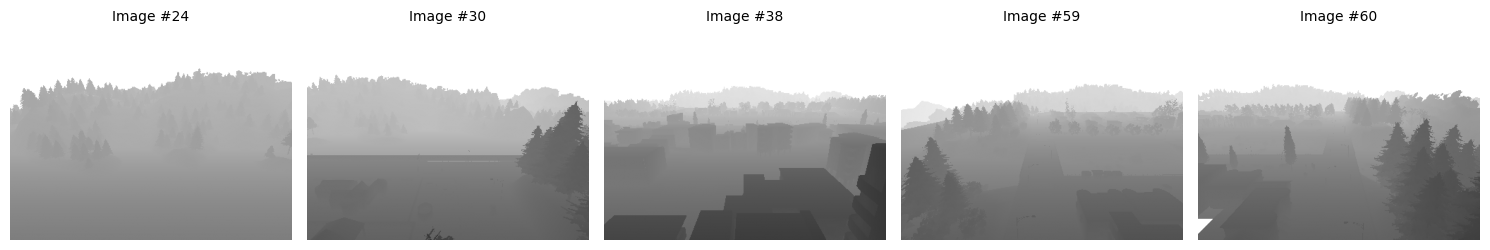

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Number of random samples to visualize
num_samples_to_show = 5

# Choose random indices from across dataset
random_indices = sorted(random.sample(range(len(samples)), num_samples_to_show))
print("Random sample indices:", random_indices)

plt.figure(figsize=(15, 5))

for i, idx in enumerate(random_indices):
    sample = samples[idx]
    img = sample["image"]  # PIL RGB image
    
    # Convert image to numpy for display (normalized 0–1)
    np_img = np.array(img) / 255.0

    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(np_img)
    plt.axis("off")
    plt.title(f"Image #{idx}", fontsize=10)

plt.tight_layout()
plt.show()


In [7]:
import torch
from transformers import (
    Blip2Processor,
    Blip2ForConditionalGeneration,
    SegformerFeatureExtractor,
    SegformerForSemanticSegmentation
)
from PIL import Image

class VisionModule:
    def __init__(self, device="cpu"):
        self.device = device
        print("Loading BLIP-2 (Flan-T5-XL) and SegFormer models...")
        
        # Captioning model
        self.caption_processor = Blip2Processor.from_pretrained("Salesforce/blip2-flan-t5-xl", use_fast=True)
        self.caption_model = Blip2ForConditionalGeneration.from_pretrained(
            "Salesforce/blip2-flan-t5-xl"
        ).to(device)

        # Segmentation model
        self.seg_processor = SegformerFeatureExtractor.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512"
        )
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512"
        ).to(device)

        print("Models loaded successfully.\n")

    def get_caption(self, image, prompt=None):
        """
        Generate caption for an image with optional UAV instruction prompt.
        Example prompt: 'Describe this image from a drone’s perspective.'
        """
        if prompt:
            inputs = self.caption_processor(images=image, text=prompt, return_tensors="pt").to(self.device)
        else:
            inputs = self.caption_processor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            caption_ids = self.caption_model.generate(**inputs, max_new_tokens=50)
        
        caption = self.caption_processor.decode(caption_ids[0], skip_special_tokens=True)
        return caption

    def get_segmentation(self, image):
        """Generate segmentation mask for a single image."""
        inputs = self.seg_processor(images=image, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.seg_model(**inputs)
        seg_mask = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()
        return seg_mask

    def process_dataset_sample(self, sample, prompts=None):
        """
        Handles a dataset item with both image + segmentation.
        Optionally generates multiple captions using UAV prompts.
        """
        image_path = sample["image_path"]
        image = Image.open(image_path).convert("RGB")

        # Generate segmentation mask
        seg_mask = self.get_segmentation(image)

        # Generate captions
        if prompts:
            captions = {p: self.get_caption(image, p) for p in prompts}
        else:
            captions = {"default": self.get_caption(image)}

        return {
            "image_path": image_path,
            "captions": captions,
            "segmentation_mask": seg_mask
        }


In [8]:
print(processed_dataset[0].keys())


dict_keys(['image_path', 'image', 'seg_inputs', 'blip_tensor'])


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP-2 (Flan-T5-XL) and SegFormer models...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uavenv/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:30: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/Users/meena/Desktop/PROJECTS/llm for uav/CODE/uavenv/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:35: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  super().__init__(*args, **kwargs)


Models loaded successfully.

Randomly chosen sample indices: [15, 28, 33]


/var/folders/9r/k7p3lsnx50d6jtxyg9lrnr9m0000gn/T/ipykernel_90431/1930615198.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


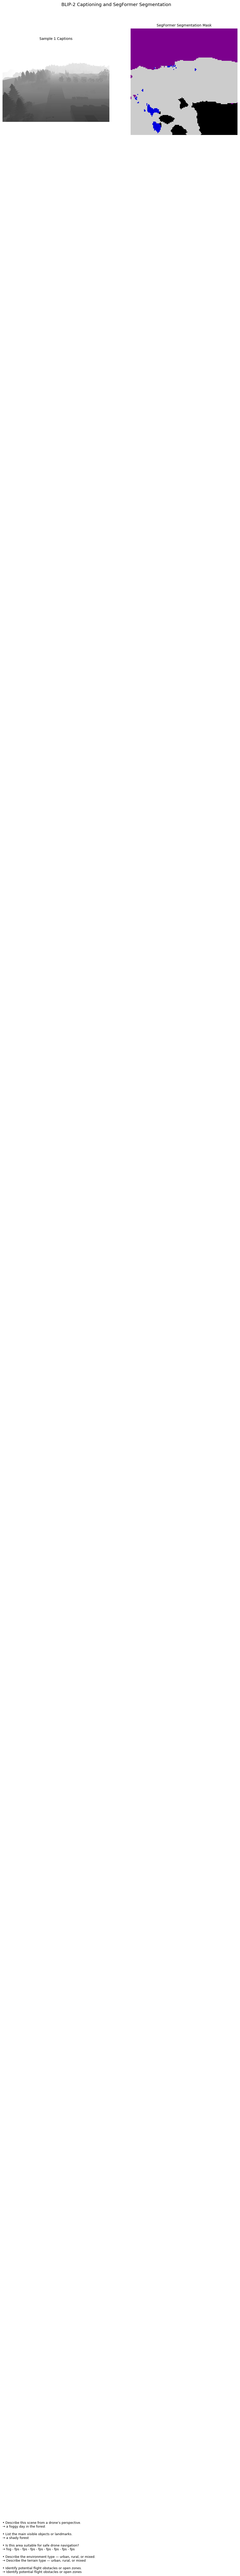

✅ Saved visualization for sample 1 at: uav_output_1.png


KeyboardInterrupt: 

In [9]:
# --- Visualization of BLIP-2 & SegFormer outputs ---
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import random

# Initialize model
vision = VisionModule(device="cpu")

# UAV-specific caption prompts for richer interpretation
uav_prompts = [
    "Describe this scene from a drone’s perspective.",
    "List the main visible objects or landmarks.",
    "Is this area suitable for safe drone navigation?",
    "Describe the environment type — urban, rural, or mixed.",
    "Identify potential flight obstacles or open zones."
]

# Randomly select samples to avoid similar scenes
random_indices = random.sample(range(len(processed_dataset)), 3)
print("Randomly chosen sample indices:", random_indices)

# Process and visualize results
for i, idx in enumerate(random_indices):
    sample = processed_dataset[idx]
    result = vision.process_dataset_sample(sample, prompts=uav_prompts)

    # Load and slightly enhance contrast for clearer features
    image = Image.open(result["image_path"]).convert("RGB")
    image = ImageEnhance.Contrast(image).enhance(1.3)

    seg_mask = result["segmentation_mask"]

    # --- Visualization ---
    plt.figure(figsize=(12, 6))
    plt.suptitle("BLIP-2 Captioning and SegFormer Segmentation", fontsize=13, y=1.02)

    # Original Image + Captions
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    captions_text = "\n\n".join([f"• {p}\n→ {c}" for p, c in result["captions"].items()])
    plt.title(f"Sample {i+1} Captions", fontsize=10)
    plt.text(
        0, -30, captions_text,
        fontsize=9,
        wrap=True,
        verticalalignment='top',
        transform=plt.gca().transAxes
    )

    # Segmentation Mask (SegFormer output)
    plt.subplot(1, 2, 2)
    plt.imshow(seg_mask, cmap="nipy_spectral")
    plt.axis("off")
    plt.title("SegFormer Segmentation Mask", fontsize=10)

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)

    # Save figure for reports
    save_path = f"uav_output_{i+1}.png"
    plt.savefig(save_path, bbox_inches="tight", dpi=200)
    plt.show()

    print(f"✅ Saved visualization for sample {i+1} at: {save_path}")


In [ ]:
# --- Clean Visualization of BLIP-2 & SegFormer Outputs ---
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import textwrap, random

# Initialize model
vision = VisionModule(device="cpu")

# UAV-specific caption prompts
uav_prompts = [
    "Describe this scene from a drone’s perspective.",
    "List the main visible objects or landmarks.",
    "Is this area suitable for safe drone navigation?",
    "Describe the environment type — urban, rural, or mixed.",
    "Identify potential flight obstacles or open zones."
]

# Randomly select samples
random_indices = random.sample(range(len(processed_dataset)), 3)
print("Randomly chosen sample indices:", random_indices)

# Visualization loop
for i, idx in enumerate(random_indices):
    sample = processed_dataset[idx]
    result = vision.process_dataset_sample(sample, prompts=uav_prompts)

    # Load and enhance contrast for better visual clarity
    image = Image.open(result["image_path"]).convert("RGB")
    image = ImageEnhance.Contrast(image).enhance(1.3)
    seg_mask = result["segmentation_mask"]

    # Combine captions into readable wrapped text
    captions_text = "\n".join([
        f"• {textwrap.fill(p, 60)}\n→ {textwrap.fill(c, 70)}"
        for p, c in result["captions"].items()
    ])

    # --- Visualization Layout ---
    fig, axes = plt.subplots(1, 2, figsize=(13, 6))
    fig.suptitle(f"Sample {i+1}: BLIP-2 Captioning & SegFormer Segmentation", fontsize=13, y=1.02)

    # Left: Raw UAV image + captions as side text
    axes[0].imshow(image)
    axes[0].axis("off")
    axes[0].set_title("BLIP-2 (Drone-Aware Captioning)", fontsize=11)

    # Display captions as text box below image
    plt.figtext(0.05, 0.02, captions_text, wrap=True, fontsize=9, va="bottom")

    # Right: Segmentation mask
    axes[1].imshow(seg_mask, cmap="nipy_spectral")
    axes[1].axis("off")
    axes[1].set_title("SegFormer Semantic Segmentation", fontsize=11)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.subplots_adjust(wspace=0.1)

    # Save and show
    save_path = f"uav_output_clean_{i+1}.png"
    plt.savefig(save_path, bbox_inches="tight", dpi=250)
    plt.show()

    print(f"✅ Saved cleaned visualization for sample {i+1} → {save_path}")


Random sample indices: [75, 88, 91]
Loading BLIP-2 (Flan-T5-XL) and SegFormer models...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Models loaded successfully.



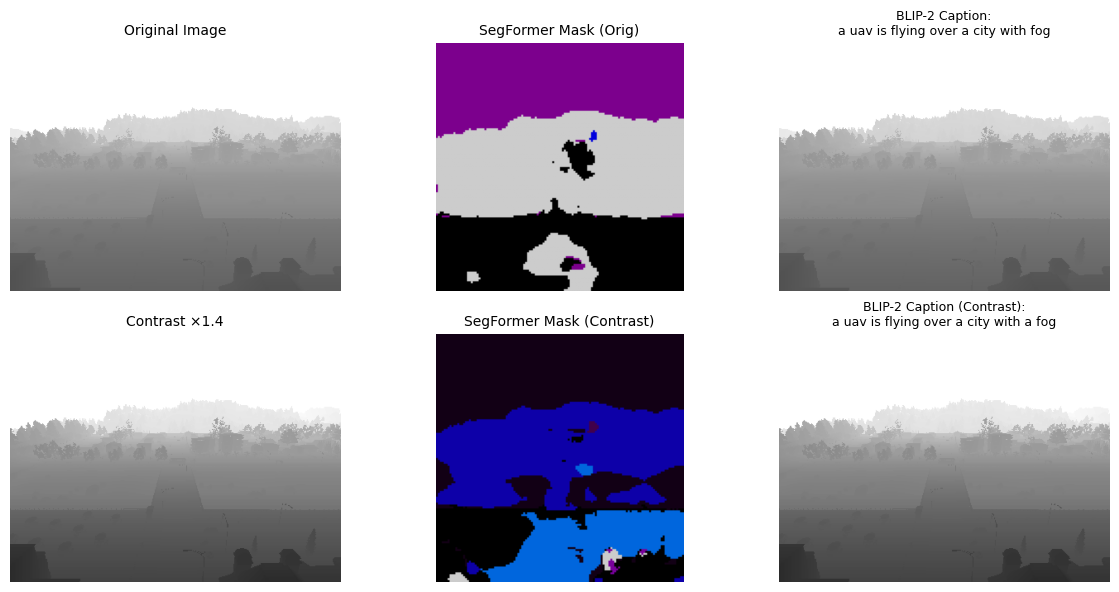

KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from PIL import Image, ImageEnhance

# Pick a few random UAV samples
num_samples_to_show = 3
random_indices = random.sample(range(len(samples)), num_samples_to_show)
print("Random sample indices:", random_indices)

# Initialize your VisionModule
vision = VisionModule(device="cpu")

# Contrast factor: 1.0 = original, >1.0 increases contrast
contrast_factor = 1.4  

for idx in random_indices:
    sample = samples[idx]
    image_path = sample["image_path"]
    image = sample["image"].convert("RGB")

    # Create a higher-contrast version
    enhancer = ImageEnhance.Contrast(image)
    contrast_image = enhancer.enhance(contrast_factor)

    # Run segmentation and captioning
    seg_mask_orig = vision.get_segmentation(image)
    seg_mask_contrast = vision.get_segmentation(contrast_image)

    caption_orig = vision.get_caption(image, prompt="Describe this UAV scene for navigation.")
    caption_contrast = vision.get_caption(contrast_image, prompt="Describe this UAV scene for navigation.")

    # Display
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(2, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image", fontsize=10)

    # Segmentation mask (original)
    plt.subplot(2, 3, 2)
    plt.imshow(seg_mask_orig, cmap="nipy_spectral")
    plt.axis("off")
    plt.title("SegFormer Mask (Orig)", fontsize=10)

    # Caption (original)
    plt.subplot(2, 3, 3)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"BLIP-2 Caption:\n{caption_orig}", fontsize=9)

    # Contrast-enhanced image
    plt.subplot(2, 3, 4)
    plt.imshow(contrast_image)
    plt.axis("off")
    plt.title(f"Contrast ×{contrast_factor}", fontsize=10)

    # Segmentation mask (contrast)
    plt.subplot(2, 3, 5)
    plt.imshow(seg_mask_contrast, cmap="nipy_spectral")
    plt.axis("off")
    plt.title("SegFormer Mask (Contrast)", fontsize=10)

    # Caption (contrast)
    plt.subplot(2, 3, 6)
    plt.imshow(contrast_image)
    plt.axis("off")
    plt.title(f"BLIP-2 Caption (Contrast):\n{caption_contrast}", fontsize=9)

    plt.tight_layout()
    plt.show()


**2) Telemetry Modality (Synthetic Data):**

In [13]:
import numpy as np
import pandas as pd

class TelemetryModule:
    def __init__(self, n_samples=100, seed=42):
        self.n_samples = n_samples
        np.random.seed(seed)

    def generate_batch(self):
        data = []
        for i in range(self.n_samples):
            entry = {
                "sample_id": i,
                "battery": np.random.randint(20, 100),  # percent
                "gps_lat": 12.84 + np.random.randn() / 1000,
                "gps_lon": 80.15 + np.random.randn() / 1000,
                "altitude_m": np.random.uniform(100, 300),
                "speed_mps": np.random.uniform(10, 50),
                "connectivity": np.random.choice(["good", "weak", "lost"])
            }
            data.append(entry)
        return pd.DataFrame(data)

# Generate and preview
telemetry = TelemetryModule(n_samples=100)
telemetry_df = telemetry.generate_batch()
print(telemetry_df.head())


   sample_id  battery    gps_lat    gps_lon  altitude_m  speed_mps  \
0          0       71  12.838888  80.150319  131.198904  12.323344   
1          1       43  12.839517  80.150164  244.399754  47.542108   
2          2       83  12.840022  80.149572  179.972194  11.866627   
3          3       81  12.840222  80.149232  176.492398  49.329235   
4          4       22  12.840417  80.150832  190.099850  10.530598   

  connectivity  
0         good  
1         weak  
2         lost  
3         good  
4         good  


In [14]:
# CSV
telemetry_df.to_csv("telemetry_data.csv", index=False)

# Optional: save numeric-only version for embeddings
numeric_cols = ["battery", "gps_lat", "gps_lon", "altitude_m", "speed_mps"]
telemetry_numeric = telemetry_df[numeric_cols].to_numpy()
np.save("telemetry_numeric.npy", telemetry_numeric)


**3) Multimodal Fusion (Image + Telemetry Embeddings):**

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# --- Fusion Module Definition ---
class FusionModule(nn.Module):
    def __init__(self, image_dim=512, telemetry_dim=5, fused_dim=256):
        super(FusionModule, self).__init__()
        self.image_proj = nn.Linear(image_dim, fused_dim)
        self.telemetry_proj = nn.Linear(telemetry_dim, fused_dim)
        self.gate = nn.Linear(fused_dim * 2, fused_dim)
        self.output_layer = nn.Linear(fused_dim, fused_dim)

    def forward(self, image_emb, telemetry_emb):
        if not torch.is_tensor(image_emb):
            image_emb = torch.tensor(image_emb, dtype=torch.float32)
        if not torch.is_tensor(telemetry_emb):
            telemetry_emb = torch.tensor(telemetry_emb, dtype=torch.float32)

        image_emb = F.normalize(image_emb, dim=-1)
        telemetry_emb = F.normalize(telemetry_emb, dim=-1)

        img_proj = torch.relu(self.image_proj(image_emb))
        tel_proj = torch.relu(self.telemetry_proj(telemetry_emb))

        combined = torch.cat([img_proj, tel_proj], dim=-1)
        gate = torch.sigmoid(self.gate(combined))
        fused = gate * img_proj + (1 - gate) * tel_proj

        fused = self.output_layer(fused)
        fused = F.normalize(fused, dim=-1)
        return fused


# --- Instantiate Fusion Model ---
fusion_model = FusionModule(image_dim=512, telemetry_dim=5, fused_dim=256)

# --- Simulated Example Data (replace these later) ---
# 100 random BLIP image embeddings (512-D)
image_embeddings = np.random.randn(100, 512)

# 100 random telemetry vectors (battery, altitude, speed, lat, lon)
telemetry_data = np.column_stack([
    np.random.randint(20, 100, size=100),          # battery %
    np.random.uniform(100, 300, size=100),         # altitude (m)
    np.random.uniform(10, 50, size=100),           # speed (m/s)
    12.84 + np.random.randn(100) / 1000,           # latitude
    80.15 + np.random.randn(100) / 1000            # longitude
])

# --- Compute Fused Embeddings for All 100 Samples ---
fused_embeddings = []

for i in tqdm(range(100), desc="Fusing vision + telemetry"):
    img_emb = image_embeddings[i]
    tel_emb = telemetry_data[i]
    fused = fusion_model(img_emb, tel_emb)
    fused_embeddings.append(fused.detach().numpy())

fused_embeddings = np.vstack(fused_embeddings)
print("\nFused Embeddings Shape:", fused_embeddings.shape)

# --- Save for RAG or downstream tasks ---
np.save("fused_embeddings.npy", fused_embeddings)
print("Saved fused embeddings to 'fused_embeddings.npy'")


Fusing vision + telemetry: 100%|██████████| 100/100 [00:00<00:00, 1753.41it/s]


Fused Embeddings Shape: (100, 256)
Saved fused embeddings to 'fused_embeddings.npy'


**4) Retrieval-Augmented Generation (RAG):**

In [ ]:
# Directory containing text documents: mission policies, flight safety, prior logs
os.makedirs("mission_docs", exist_ok=True)

# Example text file (add more mission policies later)
with open("mission_docs/flight_rules.txt", "w") as f:
    f.write("""
    If battery < 30%, the drone must divert to the nearest safe landing zone.
    If connectivity is lost, initiate return-to-home mode.
    Always maintain altitude between 100–300m.
    """)

class RAGModule:
    def __init__(self, data_dir="mission_docs/"):
        documents = SimpleDirectoryReader(data_dir).load_data()
        self.index = VectorStoreIndex.from_documents(documents)

    def retrieve(self, query):
        nodes = self.index.as_retriever().retrieve(query)
        return [n.text for n in nodes]

rag = RAGModule()

retrieved_docs = rag.retrieve("what to do when battery is low")
print("Retrieved Relevant Knowledge Base Documents:")
for doc in retrieved_docs:
    print(doc.strip())


**5) LLM Decision Reasoning:**

In [ ]:
class LLMModule:
    def __init__(self, model_name="llama-3.2-1b-gguf"):
        self.model_name = model_name
        print(f"Initialized LLM Module ({model_name})")

    def infer(self, fused_input, context_docs, telemetry_data):
        # Simplified logic for demonstration
        if telemetry_data["battery"] < 30:
            action = "divert"
            reason = "low battery"
        elif telemetry_data["connectivity"] == "lost":
            action = "return_home"
            reason = "connectivity lost"
        else:
            action = "continue"
            reason = "safe to proceed"

        output = {
            "action": action,
            "reason": reason,
            "context_ref": context_docs[:1]
        }
        return json.dumps(output, indent=2)

llm = LLMModule()
decision = llm.infer(fused_embedding, retrieved_docs, telemetry_data)

print("LLM Decision Output:")
print(decision)


**6) Full Pipeline Integration:**

In [ ]:
def run_pipeline(image_path="sample_drone_view.jpg"):
    vision = VisionModule()
    telemetry = TelemetryModule()
    fusion = FusionModule()
    rag = RAGModule()
    llm = LLMModule()

    #Vision
    image = vision.preprocess(image_path)
    caption = vision.get_caption(image)
    print("Caption:", caption)

    #Telemetry
    telemetry_data = telemetry.generate()
    print("Telemetry:", telemetry_data)

    #Fusion
    image_embedding = np.random.randn(512)
    telemetry_embedding = np.array([telemetry_data["battery"], telemetry_data["altitude"], telemetry_data["speed"]])
    fused = fusion.fuse(image_embedding, telemetry_embedding)

    #RAG
    context_docs = rag.retrieve("mission policy low battery")

    #LLM
    decision = llm.infer(fused, context_docs, telemetry_data)

    print("\n Final Decision:")
    print(decision)

# Run the entire pipeline
run_pipeline()
